# **1. Importar Librerias**

In [ ]:
# =========================
# 1. Imports y configuración inicial
# =========================

!pip install -q torch torchvision torchaudio
!pip install -q scikit-learn

import os
import zipfile
import json
import random
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import confusion_matrix, classification_report

# ----- Reproducibilidad -----
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ----- Dispositivo -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# ----- Hiperparámetros fáciles de cambiar -----
BATCH_SIZE = 32
NUM_EPOCHS = 15
LR = 1e-3
WEIGHT_DECAY = 1e-4
MODEL_NAME = "mobilenet_v2"   # podrías cambiarlo a 'mobilenet_v3_small'
NUM_CLASSES = 4               # tu dataset tiene 4 clases


Usando dispositivo: cuda


# **2. Cargar Data**

In [ ]:
# =========================
# 2. Carga del zip y descompresión
# =========================

import os
import zipfile # Added import zipfile
from google.colab import files

# Opción A: Usando ruta zip desde el PC
# ----------------------------------------------
# uploaded = files.upload()  # seleccionar el .zip de Roboflow
# DATASET_ZIP_PATH = "/content/" + list(uploaded.keys())[0]

# Opción B: Usando google drive
# --------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')
DATASET_ZIP_PATH = "/content/drive/MyDrive/Innovacion_Tecnologica_II/Ecobot.v3i.coco.zip"

print("Usando zip:", DATASET_ZIP_PATH)
assert os.path.exists(DATASET_ZIP_PATH), "El zip no existe, revisa la ruta."

# Carpeta donde se va a descomprimir
EXTRACT_DIR = "/content/dataset"
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Descomprimir
with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Contenido de EXTRACT_DIR:")
print(os.listdir(EXTRACT_DIR))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usando zip: /content/drive/MyDrive/Innovacion_Tecnologica_II/Ecobot.v3i.coco.zip
Contenido de EXTRACT_DIR:
['README.dataset.txt', 'test', 'valid', 'train', 'README.roboflow.txt']


# **3. Localizar train/val/test y clase Dataset para COCO-classification**

In [ ]:
# =========================
# 3. Descubrir carpetas train/val/test
# =========================

import glob
import os # Ensure os is imported

# The dataset structure is directly under EXTRACT_DIR
# We don't need an intermediate ROOT_DIR for the splits.

TRAIN_DIR = os.path.join(EXTRACT_DIR, "train")
VAL_DIR_1 = os.path.join(EXTRACT_DIR, "valid")
VAL_DIR_2 = os.path.join(EXTRACT_DIR, "val") # Check for 'val' as well
TEST_DIR = os.path.join(EXTRACT_DIR, "test")

VAL_DIR = None
if os.path.isdir(VAL_DIR_1):
    VAL_DIR = VAL_DIR_1
elif os.path.isdir(VAL_DIR_2):
    VAL_DIR = VAL_DIR_2

print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR:", VAL_DIR)
print("TEST_DIR:", TEST_DIR)

# Optional: Add assertions to ensure directories exist
assert os.path.isdir(TRAIN_DIR), f"Error: Train directory not found at {TRAIN_DIR}"
if VAL_DIR:
    assert os.path.isdir(VAL_DIR), f"Error: Validation directory not found at {VAL_DIR}"
assert os.path.isdir(TEST_DIR), f"Error: Test directory not found at {TEST_DIR}"

TRAIN_DIR: /content/dataset/train
VAL_DIR: /content/dataset/valid
TEST_DIR: /content/dataset/test


In [ ]:
# =========================
# 3b. Clase Dataset COCO → Clasificación
# =========================

from torch.utils.data import Dataset
import json
from collections import Counter
import os # Ensure os is imported for path operations
from PIL import Image # Ensure PIL is imported for Image.open

class CocoClassificationDataset(Dataset):
    """
    Dataset para COCO de Roboflow pero usado como clasificación:
    - Asume 1 anotación (1 categoría) por imagen.
    - Usa el nombre de categoría como label.
    """
    def __init__(self, images_dir, annotation_path, transform=None, class_to_idx=None):
        self.images_dir = images_dir
        self.annotation_path = annotation_path
        self.transform = transform

        with open(annotation_path, "r") as f:
            data = json.load(f)

        self.images_info = data["images"]
        self.annotations = data["annotations"]
        self.categories = data["categories"]

        # Mapear category_id -> category_name
        self.cat_id_to_name = {cat["id"]: cat["name"] for cat in self.categories}

        # Si no nos dan mapping, lo construimos (orden por id de categoría)
        if class_to_idx is None:
            # Filter out 'objects' class and then sort by id
            filtered_cats = [c for c in self.categories if c["name"] != "objects"]
            sorted_cats = sorted(filtered_cats, key=lambda x: x["id"])
            self.class_names = [c["name"] for c in sorted_cats]
            self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        else:
            self.class_to_idx = class_to_idx
            # Aseguramos que la lista de nombres esté ordenada por índice
            self.class_names = [None] * len(class_to_idx)
            for name, idx in class_to_idx.items():
                self.class_names[idx] = name

        # Mapear image_id -> file_name
        self.image_id_to_file = {}
        for img in self.images_info:
            original_file_name = img["file_name"]
            # Roboflow sometimes includes the 'images/' prefix in the file_name within the JSON.
            # Ensure we only get the base filename.
            if original_file_name.startswith('images/'):
                base_file_name = original_file_name[len('images/'):]
            else:
                base_file_name = original_file_name
            self.image_id_to_file[img["id"]] = base_file_name

        # Elegir la categoría para cada imagen y solo considerar las clases válidas
        image_id_to_catname = {}
        for ann in self.annotations:
            image_id = ann["image_id"]
            cat_id = ann["category_id"]
            cat_name = self.cat_id_to_name[cat_id]
            # Only consider annotations for classes that are in our class_to_idx mapping
            if cat_name in self.class_to_idx:
                # Si hubiera varias anotaciones por imagen, nos quedamos con la primera
                if image_id not in image_id_to_catname:
                    image_id_to_catname[image_id] = cat_name

        # Construir lista de muestras (ruta_imagen, label_idx)
        self.samples = []
        for image_id, file_name in self.image_id_to_file.items():
            if image_id not in image_id_to_catname:
                # Sin anotación o anotación no deseada -> lo ignoramos
                continue
            class_name = image_id_to_catname[image_id]
            label_idx = self.class_to_idx[class_name]
            img_path = os.path.join(images_dir, file_name)
            self.samples.append((img_path, label_idx))

        # Contar ejemplos por clase
        labels = [s[1] for s in self.samples]
        self.class_counts = Counter(labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# **4. Transformaciones y creación de DataLoaders**

In [ ]:
# =========================
# 4. Transformaciones y DataLoaders
# =========================

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import defaultdict
import os

# Hyperparameters from initial setup, added here for robustness
BATCH_SIZE = 32

# Transformaciones (ImageNet-style para MobileNet)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# Ruta a los JSON
train_ann = os.path.join(TRAIN_DIR, "_annotations.coco.json")
val_ann = os.path.join(VAL_DIR, "_annotations.coco.json") if VAL_DIR else None
test_ann = os.path.join(TEST_DIR, "_annotations.coco.json")

# Determine actual image directories (robust to Roboflow export variants)
def get_images_dir(split_dir):
    if split_dir is None:
        return None
    potential_images_sub_dir = os.path.join(split_dir, "images")
    if os.path.isdir(potential_images_sub_dir):
        return potential_images_sub_dir
    return split_dir # Assume images are directly in split_dir

train_images_dir = get_images_dir(TRAIN_DIR)
val_images_dir = get_images_dir(VAL_DIR)
test_images_dir = get_images_dir(TEST_DIR)


# Primero creamos el dataset de train para obtener la mapping class_to_idx
train_tmp_dataset = CocoClassificationDataset(
    images_dir=train_images_dir,
    annotation_path=train_ann,
    transform=train_transform,
    class_to_idx=None
)

class_to_idx = train_tmp_dataset.class_to_idx
class_names = train_tmp_dataset.class_names
print("Clases (class_to_idx):")
for name, idx in class_to_idx.items():
    print(f"  {name}: {idx}")

# Ahora creamos datasets definitivos (usando el mismo mapping)
train_dataset = train_tmp_dataset

val_dataset = None
if VAL_DIR and os.path.exists(val_ann):
    val_dataset = CocoClassificationDataset(
        images_dir=val_images_dir,
        annotation_path=val_ann,
        transform=val_test_transform,
        class_to_idx=class_to_idx
    )

test_dataset = CocoClassificationDataset(
    images_dir=test_images_dir,
    annotation_path=test_ann,
    transform=val_test_transform,
    class_to_idx=class_to_idx
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False) if val_dataset else None
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# Resumen de imágenes por split y por clase
def print_split_stats(name, dataset):
    print(f"\n[{name}] Número total de imágenes: {len(dataset)}")
    counts = defaultdict(int)
    for _, label in dataset.samples:
        counts[label] += 1
    for label_idx, count in sorted(counts.items()):
        print(f"  Clase {label_idx} ({class_names[label_idx]}): {count} imágenes")

print_split_stats("Train", train_dataset)
if val_dataset:
    print_split_stats("Val", val_dataset)
print_split_stats("Test", test_dataset)

Clases (class_to_idx):
  Botellita: 0
  Lata: 1
  Pet: 2
  Tetra: 3

[Train] Número total de imágenes: 2461
  Clase 0 (Botellita): 543 imágenes
  Clase 1 (Lata): 846 imágenes
  Clase 2 (Pet): 309 imágenes
  Clase 3 (Tetra): 763 imágenes

[Val] Número total de imágenes: 182
  Clase 0 (Botellita): 45 imágenes
  Clase 1 (Lata): 61 imágenes
  Clase 2 (Pet): 22 imágenes
  Clase 3 (Tetra): 54 imágenes

[Test] Número total de imágenes: 180
  Clase 0 (Botellita): 45 imágenes
  Clase 1 (Lata): 61 imágenes
  Clase 2 (Pet): 22 imágenes
  Clase 3 (Tetra): 52 imágenes


# **5. Modelo MobileNet + Transfer Learning**

-  Transfer learning: usamos un modelo preentrenado en ImageNet (millones de imágenes) y solo adaptamos las últimas capas para nuestras 4 clases. Así aprovechamos las características ya aprendidas y entrenamos mucho más rápido y con menos datos.
-  MobileNet: es una arquitectura ligera diseñada para dispositivos móviles / edge (pocas operaciones, parámetros y memoria), ideal para luego exportar a TFLite/ONNX y correr en procesadores con recursos limitados.

In [ ]:
# =========================
# 5. Definir MobileNet + Transfer Learning
# =========================

if MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
elif MODEL_NAME == "mobilenet_v3_small":
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, NUM_CLASSES)
else:
    raise ValueError("MODEL_NAME debe ser 'mobilenet_v2' o 'mobilenet_v3_small'.")

# Congelar capas base (feature extractor)
for name, param in model.named_parameters():
    param.requires_grad = False

# Solo el clasificador se entrena inicialmente
if MODEL_NAME == "mobilenet_v2":
    for param in model.classifier.parameters():
        param.requires_grad = True
else:
    for param in model.classifier.parameters():
        param.requires_grad = True

model = model.to(device)

# Parámetros entrenables
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(f"Número de parámetros entrenables: {sum(p.numel() for p in trainable_params):,}")
print(model)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 156MB/s]


Número de parámetros entrenables: 5,124
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fa

# **6. Entrenamiento (fase 1: solo clasificador, fase 2: fine-tuning)**

In [ ]:
# =========================
# 6. Entrenamiento
# =========================

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # opcional

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        torch.cuda.empty_cache() # Speculative fix: clear CUDA cache before transfer
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

best_val_acc = 0.0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

BEST_MODEL_PATH = "best_mobilenet_classification.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

    if val_loader is not None:
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    else:
        # Si no hay val, usamos test temporalmente (no ideal, pero por si acaso)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Guardar el mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"  -> Nuevo mejor modelo guardado (val_acc = {best_val_acc:.4f})")

print("Entrenamiento finalizado. Mejor val_acc:", best_val_acc)


Epoch [1/15] Train Loss: 0.9572 Acc: 0.6132 | Val Loss: 0.5281 Acc: 0.8736
  -> Nuevo mejor modelo guardado (val_acc = 0.8736)
Epoch [2/15] Train Loss: 0.5297 Acc: 0.8537 | Val Loss: 0.3259 Acc: 0.9835
  -> Nuevo mejor modelo guardado (val_acc = 0.9835)
Epoch [3/15] Train Loss: 0.4216 Acc: 0.8818 | Val Loss: 0.2583 Acc: 0.9670
Epoch [4/15] Train Loss: 0.3679 Acc: 0.8809 | Val Loss: 0.2386 Acc: 0.9615
Epoch [5/15] Train Loss: 0.3398 Acc: 0.8911 | Val Loss: 0.2158 Acc: 0.9505
Epoch [6/15] Train Loss: 0.3102 Acc: 0.9069 | Val Loss: 0.1983 Acc: 0.9670
Epoch [7/15] Train Loss: 0.3100 Acc: 0.9106 | Val Loss: 0.1973 Acc: 0.9615
Epoch [8/15] Train Loss: 0.2970 Acc: 0.9098 | Val Loss: 0.1908 Acc: 0.9780
Epoch [9/15] Train Loss: 0.2926 Acc: 0.9143 | Val Loss: 0.1762 Acc: 0.9780
Epoch [10/15] Train Loss: 0.2888 Acc: 0.9122 | Val Loss: 0.1767 Acc: 0.9780
Epoch [11/15] Train Loss: 0.2909 Acc: 0.9147 | Val Loss: 0.1697 Acc: 0.9835
Epoch [12/15] Train Loss: 0.2803 Acc: 0.9155 | Val Loss: 0.1874 Acc: 

# **7. Fine-tuning: descongelar algunas capas**

In [ ]:
# =========================
# 7. Fine-tuning opcional
# =========================

FINE_TUNE = True  # cambia a True si quieres hacer fine-tuning

if FINE_TUNE:
    # Cargar el mejor modelo obtenido antes
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))

    # Descongelar algunas capas del feature extractor
    for name, param in model.named_parameters():
        if "features.14" in name or "features.15" in name or "features.16" in name:
            param.requires_grad = True

    # Re-definir optimizer sólo con parámetros entrenables
    fine_tune_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(fine_tune_params, lr=1e-4, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    FINE_TUNE_EPOCHS = 5
    for epoch in range(1, FINE_TUNE_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device) if val_loader else evaluate(model, test_loader, criterion, device)
        scheduler.step()

        print(f"[Fine-tune] Epoch [{epoch}/{FINE_TUNE_EPOCHS}] "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"  -> Nuevo mejor modelo (fine-tune) guardado (val_acc = {best_val_acc:.4f})")


[Fine-tune] Epoch [1/5] Train Loss: 0.2464 Acc: 0.9301 | Val Loss: 0.0670 Acc: 0.9945
  -> Nuevo mejor modelo (fine-tune) guardado (val_acc = 0.9945)
[Fine-tune] Epoch [2/5] Train Loss: 0.1083 Acc: 0.9687 | Val Loss: 0.0371 Acc: 1.0000
  -> Nuevo mejor modelo (fine-tune) guardado (val_acc = 1.0000)
[Fine-tune] Epoch [3/5] Train Loss: 0.0618 Acc: 0.9842 | Val Loss: 0.0255 Acc: 0.9945
[Fine-tune] Epoch [4/5] Train Loss: 0.0434 Acc: 0.9931 | Val Loss: 0.0250 Acc: 0.9945
[Fine-tune] Epoch [5/5] Train Loss: 0.0403 Acc: 0.9919 | Val Loss: 0.0261 Acc: 0.9945


# **8. Curvas de entrenamiento (loss y accuracy)**

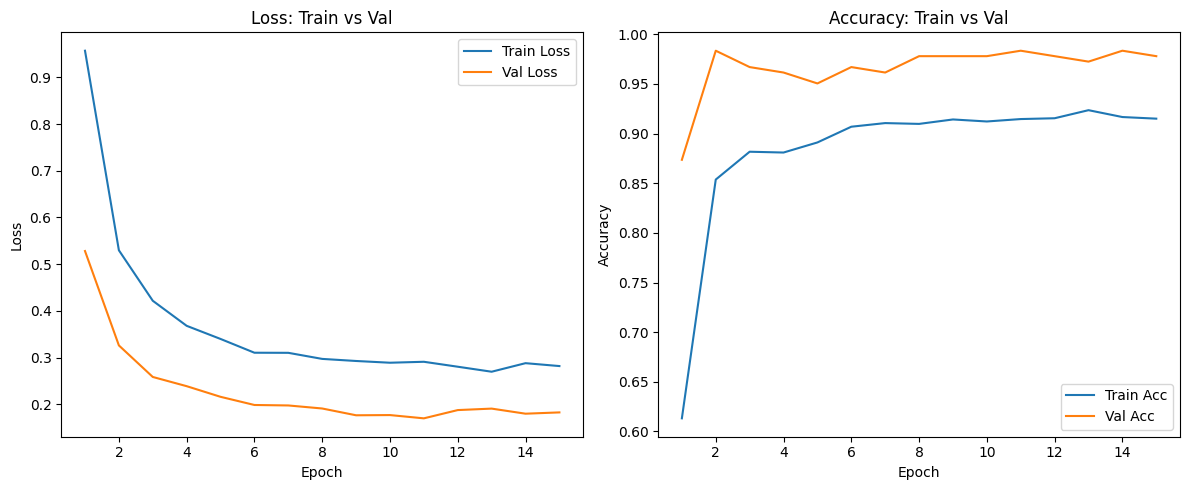

In [ ]:
# =========================
# 8. Curvas de entrenamiento
# =========================

epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss: Train vs Val")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy: Train vs Val")
plt.legend()

plt.tight_layout()
plt.show()


# **9. Evaluación final en el test set**

In [ ]:
# =========================
# 9. Evaluación en Test
# =========================

# Cargar el mejor modelo
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = (all_preds == all_labels).mean()
print(f"Accuracy global en Test: {test_acc:.4f}")

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión:\n", cm)

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("Classification report:\n", report)


Accuracy global en Test: 0.9778
Matriz de confusión:
 [[43  0  2  0]
 [ 0 59  0  2]
 [ 0  0 22  0]
 [ 0  0  0 52]]
Classification report:
               precision    recall  f1-score   support

   Botellita     1.0000    0.9556    0.9773        45
        Lata     1.0000    0.9672    0.9833        61
         Pet     0.9167    1.0000    0.9565        22
       Tetra     0.9630    1.0000    0.9811        52

    accuracy                         0.9778       180
   macro avg     0.9699    0.9807    0.9746       180
weighted avg     0.9791    0.9778    0.9779       180



# **10. Gráfico de matriz de confusión**

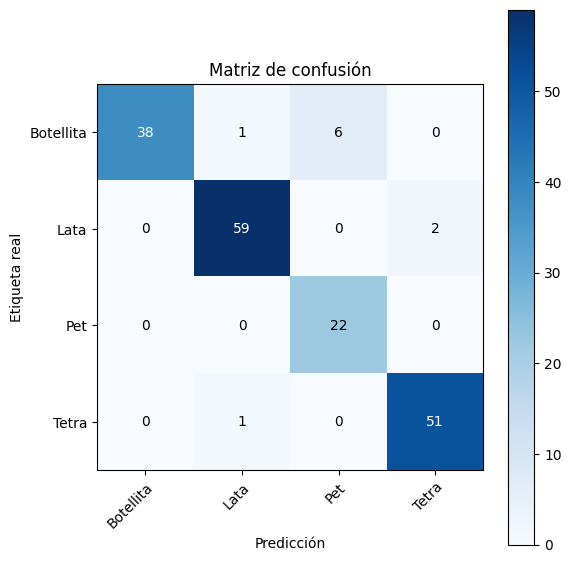

In [ ]:
# =========================
# 10. Gráfico de matriz de confusión
# =========================

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='Etiqueta real',
    xlabel='Predicción'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()


# **11. Mostrar algunas imágenes de test con predicción**

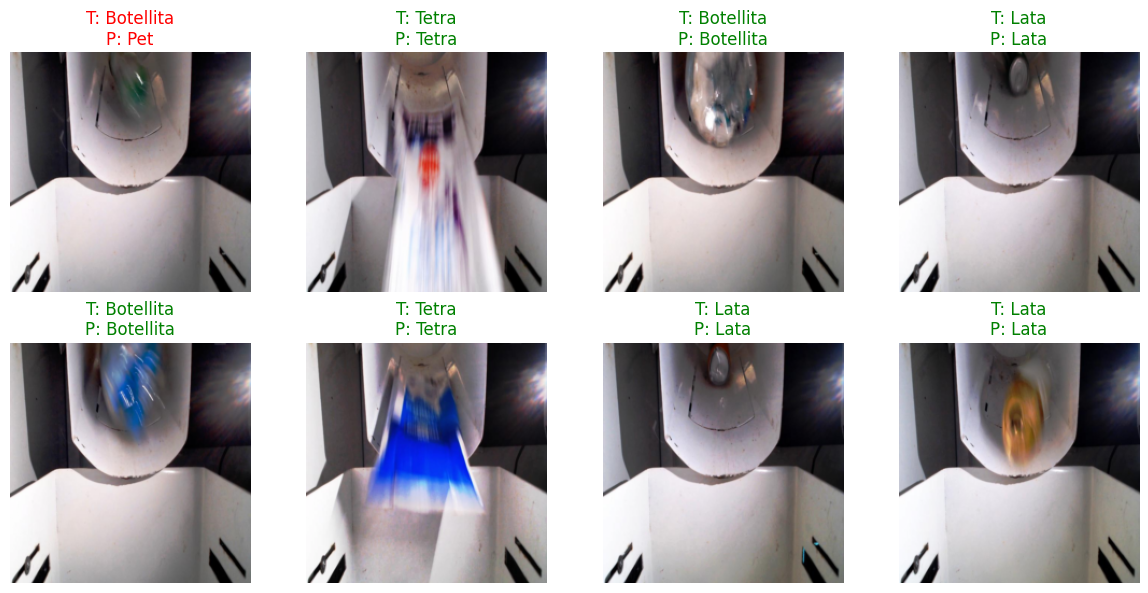

In [ ]:
# =========================
# 11. Visualización de predicciones
# =========================

def denormalize(img_tensor, mean, std):
    """Deshace la normalización para mostrar imágenes."""
    img = img_tensor.clone().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = torch.clamp(img, 0, 1)
    return img

model.eval()
images_shown = 8
shown = 0

plt.figure(figsize=(12, 6))

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if shown >= images_shown:
                break
            img_denorm = denormalize(images[i], imagenet_mean, imagenet_std)
            img_np = np.transpose(img_denorm.cpu().numpy(), (1, 2, 0))

            plt.subplot(2, images_shown//2, shown+1)
            plt.imshow(img_np)
            true_label = class_names[labels[i].item()]
            pred_label = class_names[preds[i].item()]
            color = "green" if labels[i].item() == preds[i].item() else "red"
            plt.title(f"T: {true_label}\nP: {pred_label}", color=color)
            plt.axis("off")
            shown += 1

        if shown >= images_shown:
            break

plt.tight_layout()
plt.show()


# **12. Guardar el modelo (.pth) y ejemplo de exportación a TorchScript / ONNX**

In [ ]:
# =========================
# 12. Guardar modelo y exportar
# =========================

!pip install onnx # Install ONNX for export functionality

# El mejor modelo ya está guardado como BEST_MODEL_PATH (state_dict)
print("Modelo guardado en:", BEST_MODEL_PATH)

# Opcional: exportar a TorchScript
DUMMY_INPUT = torch.randn(1, 3, 224, 224).to(device)
traced_script_module = torch.jit.trace(model, DUMMY_INPUT)
traced_script_module.save("mobilenet_coco_classification_ts.pt")
print("Modelo TorchScript guardado en mobilenet_coco_classification_ts.pt")

# Opcional: exportar a ONNX (primer paso para despliegue en otros runtimes)
onnx_path = "mobilenet_coco_classification.onnx"
torch.onnx.export(
    model,
    DUMMY_INPUT,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],
    opset_version=11
)
print("Modelo ONNX guardado en:", onnx_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 121.2 MB/s eta 0:00:00
Modelo guardado en: best_mobilenet_classification.pth
Modelo TorchScript guardado en mobilenet_coco_classification_ts.pt


/tmp/ipython-input-807121164.py:18: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Modelo ONNX guardado en: mobilenet_coco_classification.onnx


### **13. Tiempo estimado de predicción por imagen**

In [ ]:
import time

# Cargar el mejor modelo
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# Obtener una imagen de ejemplo del test_loader
# Usaremos una sola imagen para medir el tiempo de inferencia
example_image, _ = next(iter(test_loader))
example_image = example_image[0].unsqueeze(0).to(device) # Tomar la primera imagen del batch y añadir dimensión de batch

# Calentar la GPU (primera inferencia puede ser más lenta)
_ = model(example_image)

# Medir el tiempo de inferencia para una sola imagen
num_measurements = 100
times = []

for _ in range(num_measurements):
    start_time = time.time()
    with torch.no_grad():
        _ = model(example_image)
    end_time = time.time()
    times.append(end_time - start_time)

mean_inference_time_ms = np.mean(times) * 1000
std_inference_time_ms = np.std(times) * 1000

print(f"Tiempo de predicción estimado por imagen: {mean_inference_time_ms:.3f} +/- {std_inference_time_ms:.3f} ms")

Tiempo de predicción estimado por imagen: 7.337 +/- 1.603 ms
